One potentially interesting option when full FreeSurfer output per subject is avaliable, is to resample each participants surface metrics of interest in a standard space. While we could go from native freesurfer space to a freesurfer common space, in this example we will use resample data into the fs LR 32k common space from the HCP project. To do this, we will use a python wrapper made avaliable through the package neurotools, which wraps commands from the HCP workbench.

To download just the extra data needed here + assuming datalad was used,
the following command was run from inside the main data ds003097 directory.
Note: this was performed on unix, this command will likely differ on windows.

`datalad get derivatives/fmriprep/sub-*/anat/sub-*_hemi-*_midthickness.surf.gii derivatives/freesurfer/sub-*/surf/*.sphere.reg derivatives/freesurfer/sub-*/surf/*.area derivatives/freesurfer/sub-*/surf/*.thickness`

Which downloads the midthickness files, regularized sphere files, thickness and area for
each subject in their native freesurfer space.

In [1]:
from neurotools.resample.wrappers import resample_fs_native_to_fs_LR
from os.path import dirname, abspath
import os
import numpy as np

/home/sage/anaconda3/envs/bpt/lib/python3.9/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
# Useful directories
main_dr = dirname(abspath(os.getcwd()))
data_dr = os.path.join(main_dr, 'data')
deriv_dr = os.path.join(data_dr, 'ds003097', 'derivatives')

We will start by showing an example for re-sampling a single participent, and a single hemisphere.

In [3]:
# We will setup the args below so
# so that we just need to change these
# parameters when running on all subjects
subj = '0001'
hemi = 'lh'

# The subject's freesurfer directory - though since we
# are using the midthickness file as calculated from frmiprep
# the only file we actually use / need from this subject's directory
# is the sphere.reg lh and rh files.
fs_subj = os.path.join(deriv_dr, 'freesurfer', f'sub-{subj}')

# The data to re-sample
data_loc = os.path.join(fs_subj, 'surf', f'{hemi}.thickness')

# The resolution we are re-sampling to
target_res = '32k'

# Since fmriprep already calculated this file
# and saved it as gifti, use that
mid_thick_loc = os.path.join(deriv_dr, 'fmriprep',
                             f'sub-{subj}', 'anat',
                             f'sub-{subj}_hemi-{hemi[0].upper()}_midthickness.surf.gii')

In [4]:
resampled_data = resample_fs_native_to_fs_LR(data=data_loc, fs_subj=fs_subj,
                                             hemi=hemi, target_res=target_res,
                                             midthickness_loc=mid_thick_loc,
                                             area_correction=True)
resampled_data.shape

(32492,)

The shape looks correct, let's plot both the re-sampled version, and the data from the original space

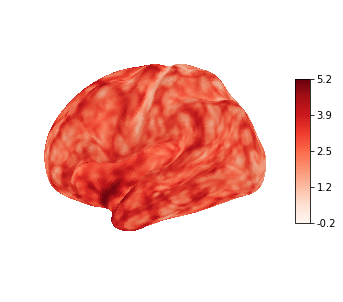

In [5]:
from neurotools.plotting import plot

# Use automated plot function
plot(resampled_data, threshold=None, bg_map=None)

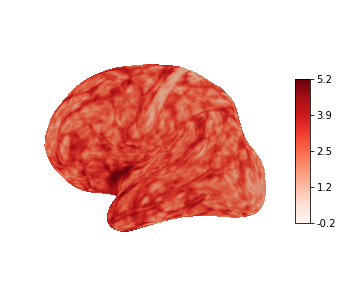

In [6]:
from nibabel.freesurfer.io import read_geometry

# Load the inflated suface in original space
orig_surf_mesh = read_geometry(os.path.join(fs_subj, 'surf', f'{hemi}.inflated'))

# In order to plot data in native space
# we need to pass data in a dict, and pass the custom
# surf mesh w/ neurotools automated plot function.
plot(data={hemi: data_loc},
     surf_mesh=orig_surf_mesh,
     bg_map=None, 
     threshold=None)

Okay not bad, now we can go through and resample for every subject, both lh and rh. We will then concatenate their data and save it. We will write a function for this process below.

In [7]:
def resample_and_save(subj, to_resample=['thickness', 'area']):

    data = []
    
    # Freesurfer subj directory
    fs_subj = os.path.join(deriv_dr, 'freesurfer', f'sub-{subj}')
    
    # For both hemispheres
    for hemi in ['lh', 'rh']:
        
        # Mid thickness loc
        mid_thick_loc = os.path.join(deriv_dr, 'fmriprep',
                                     f'sub-{subj}', 'anat',
                                     f'sub-{subj}_hemi-{hemi[0].upper()}_midthickness.surf.gii')
        
        # List of data to re-sample
        data_locs = [os.path.join(fs_subj, 'surf', f'{hemi}.{r}') for r in to_resample]
        
        # Resample - returns list of 3
        resampled_data = resample_fs_native_to_fs_LR(data=data_locs,
                                                     fs_subj=fs_subj,
                                                     hemi=hemi,
                                                     target_res='32k',
                                                     midthickness_loc=mid_thick_loc,
                                                     area_correction=True)
        
        # Keep track
        data.append(resampled_data)
    
    # Concat lh+rh and put in a dictionary index'ed by resampled name
    data = {to_resample[i]: np.concatenate([data[0][i], data[1][i]])
            for i in range(len(to_resample))}
    
    # Save each modality seperate in new resampled_surfs directory
    for key in data:
        
        # Gen save directory path
        save_dr = os.path.join(deriv_dr, 'resampled_surfs', f'sub-{subj}')
        os.makedirs(save_dr, exist_ok=True)
        
        # Save as numpy array
        save_loc = os.path.join(save_dr, f'{key}.npy')
        np.save(save_loc, data[key])

In [8]:
# Run for the first subject
data = resample_and_save(subj='0001')

Okay - the function is fairly fast, but this is a nice chance to show how we might speed things up a bit with multi-processing (Note: we won't get a huge huge speed boost as the underlying workbench resampling functions actually do use their own multi-threading procedure - but we can still get higher cpu utiliziation - on my pc the speedup was ~3-4x faster on a sub-sample of 50 subjects!)

In [9]:
from joblib import Parallel, delayed

# Get a list of all of the subject names
main_subjs_dr = os.path.join(data_dr, 'ds003097')
subjs = [s.split('-')[-1] for s in os.listdir(main_subjs_dr) if 'sub' in s]

# Run with all avaliable cores
# Note: when restarting this notebook if this step
# is already complete, it is likely a good idea to comment it out.
#Parallel(n_jobs=-1)(delayed(resample_and_save)(subj) for subj in subjs)

## Prepare as BPt Dataset for future use

In [10]:
import BPt as bp

# Load the base template dataframe with targets loaded
data = bp.read_pickle(os.path.join(data_dr, 'datasets', 'template.dataset'))

Next we add the data files we prepared in this notebook as features to the Dataset

In [11]:
# We use file globbing here to specify which files we want to 'load'
base_glob = os.path.join(deriv_dr, 'resampled_surfs', 'sub-*')

files = {'thickness': os.path.join(base_glob, 'thickness.npy'),
         'area': os.path.join(base_glob, 'area.npy')}

# The auto function is smart, just from the filenames it can figure
# out what the correct index should be
data = data.add_data_files(files, file_to_subject='auto')
data

,area,thickness
participant_id,,
sub-0001,Loc(1484),Loc(556)
sub-0002,Loc(1736),Loc(808)
sub-0003,Loc(1211),Loc(283)
sub-0004,Loc(1748),Loc(820)
sub-0005,Loc(1240),Loc(312)
...,...,...
sub-0924,Loc(1743),Loc(815)
sub-0925,Loc(1372),Loc(444)
sub-0926,Loc(1483),Loc(555)


Plot all input data (note for the datafiles, the default behavior is to plot the mean value)

area: 928 rows


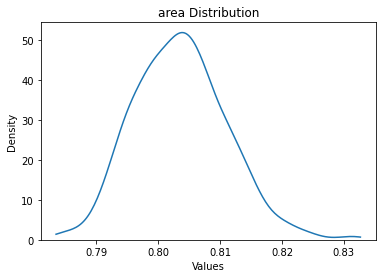

thickness: 928 rows


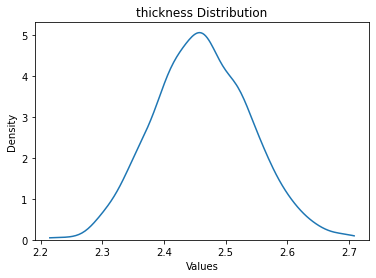

In [12]:
data.plot('data')

We just want to check here if the distributions look reasonable, and they do, or atleast for this average value view.

We can also pass other custom measures to plot if we want

area: 928 rows


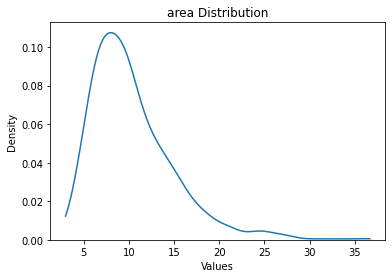

thickness: 928 rows


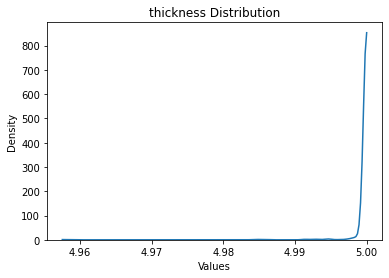

In [13]:
data.plot('data', reduce_func=np.max)

area: 928 rows


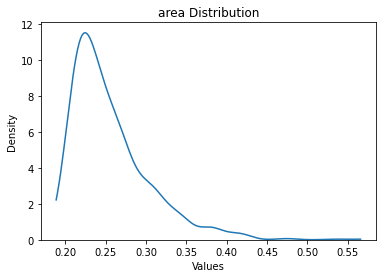

thickness: 928 rows


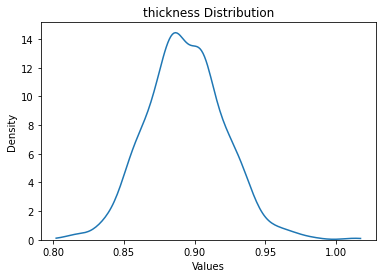

In [14]:
data.plot('data', reduce_func=np.std)

Lastly, save the dataset so we can use it in other notebooks / contexts.

In [15]:
data.to_pickle(os.path.join(data_dr, 'datasets', 'fs_surf.dataset'))